In [1]:
# ========================
# 1. Import Libraries
# ========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style='whitegrid', palette='muted', font_scale=1.1)


# Paths
RAW = Path('data/raw')
PROC = Path('data/processed')
PROC.mkdir(parents=True, exist_ok=True)

In [2]:
# ========================
# 2. Load Raw Dataset
# ========================

# Path to the raw data (note the '..' since the notebook is inside /notebooks)
from pathlib import Path

RAW = Path('../data/raw')
file_path = RAW / 'Smart_Fertilizer_Recommender_Dataset.xlsx'

# Load dataset
df = pd.read_excel(file_path)
print('✅ Initial Shape:', df.shape)

# Preview first few rows
df.head()


✅ Initial Shape: (1000, 15)


,Crop_Type,Region,Soil_Type,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Organic_Carbon,Moisture_Content,Rainfall_mm,Temperature_C,Plant_Age_Weeks,Fertilizer_Type,Recommended_Quantity_kg_per_acre,Application_Timing
0,Groundnut,Tamil Nadu,Sandy,4.92,131.63,21.79,242.19,1.57,27.89,955.55,24.98,14,Complex,86.50,Before sowing
1,Sugarcane,Uttar Pradesh,Sandy,7.13,53.08,64.54,65.49,0.57,26.65,756.71,39.50,17,Potash,54.24,Before sowing
2,Millet,Andhra Pradesh,Sandy,7.79,166.59,86.45,194.20,1.48,15.84,146.84,20.65,18,Urea,30.84,Before sowing
3,Cotton,Gujarat,Sandy,6.02,100.62,14.05,79.80,0.24,8.00,895.82,30.30,19,DAP,92.50,Flowering stage
4,Groundnut,Maharashtra,Silty,7.60,140.05,76.07,59.12,0.95,8.18,876.41,25.82,17,MOP,183.12,After sowing


In [3]:
# ========================
# 3. Handle Missing Values & Data Cleaning
# ========================


# Check missing values
print('Missing Values per Column:')
print(df.isnull().sum())


# Fill missing numeric values with median
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())


# Fill categorical with mode
cat_cols = df.select_dtypes(exclude=np.number).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))


# Check again
print('After Cleaning:')
print(df.isnull().sum().sum(), 'missing values remain')

Missing Values per Column:
Crop_Type                           0
Region                              0
Soil_Type                           0
Soil_pH                             0
Nitrogen_Level                      0
Phosphorus_Level                    0
Potassium_Level                     0
Organic_Carbon                      0
Moisture_Content                    0
Rainfall_mm                         0
Temperature_C                       0
Plant_Age_Weeks                     0
Fertilizer_Type                     0
Recommended_Quantity_kg_per_acre    0
Application_Timing                  0
dtype: int64
After Cleaning:
0 missing values remain


In [4]:
# ========================
# 4. Feature Engineering
# ========================

def feature_engineering(df):
    df = df.copy()
    
    # Derived ratios and indices
    df['NPK_Ratio'] = df['Nitrogen_Level'] / (df['Phosphorus_Level'] + df['Potassium_Level'] + 1e-6)
    df['Fertility_Index'] = (df['Organic_Carbon'] + (df['Moisture_Content'] / 100)) / 2
    df['Temperature_Rainfall_Index'] = df['Temperature_C'] / (df['Rainfall_mm'] + 1)
    
    # pH categorization
    df['pH_Category'] = pd.cut(
        df['Soil_pH'],
        bins=[0, 5.5, 6.5, 7.5, 14],
        labels=['Acidic', 'Slightly_Acidic', 'Neutral', 'Alkaline']
    )
    
    # Simplify fertilizer categories if needed
    df['Fertilizer_Type'] = df['Fertilizer_Type'].replace({
        'Complex': 'Mixed',
        'MOP': 'Potash'
    })
    
    return df


# Apply feature engineering
df = feature_engineering(df)
print('✅ Feature Engineering Complete. Columns:', len(df.columns))
df.head()


✅ Feature Engineering Complete. Columns: 19


,Crop_Type,Region,Soil_Type,Soil_pH,Nitrogen_Level,Phosphorus_Level,Potassium_Level,Organic_Carbon,Moisture_Content,Rainfall_mm,Temperature_C,Plant_Age_Weeks,Fertilizer_Type,Recommended_Quantity_kg_per_acre,Application_Timing,NPK_Ratio,Fertility_Index,Temperature_Rainfall_Index,pH_Category
0,Groundnut,Tamil Nadu,Sandy,4.92,131.63,21.79,242.19,1.57,27.89,955.55,24.98,14,Mixed,86.50,Before sowing,0.498636,0.92445,0.026115,Acidic
1,Sugarcane,Uttar Pradesh,Sandy,7.13,53.08,64.54,65.49,0.57,26.65,756.71,39.50,17,Potash,54.24,Before sowing,0.408213,0.41825,0.052131,Neutral
2,Millet,Andhra Pradesh,Sandy,7.79,166.59,86.45,194.20,1.48,15.84,146.84,20.65,18,Urea,30.84,Before sowing,0.593586,0.81920,0.139678,Alkaline
3,Cotton,Gujarat,Sandy,6.02,100.62,14.05,79.80,0.24,8.00,895.82,30.30,19,DAP,92.50,Flowering stage,1.072136,0.16000,0.033786,Slightly_Acidic
4,Groundnut,Maharashtra,Silty,7.60,140.05,76.07,59.12,0.95,8.18,876.41,25.82,17,Potash,183.12,After sowing,1.035949,0.51590,0.029428,Alkaline


In [5]:
# ========================
# 5. Encoding Categorical Variables
# ========================

from sklearn.preprocessing import LabelEncoder

categorical_cols = ['Crop_Type', 'Region', 'Soil_Type', 'pH_Category', 'Application_Timing']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # ensure dtype safety
    label_encoders[col] = le

print('✅ Categorical Encoding Complete.')
df[categorical_cols].head()


✅ Categorical Encoding Complete.


,Crop_Type,Region,Soil_Type,pH_Category,Application_Timing
0,1,6,3,0,1
1,7,7,3,2,1
2,3,0,3,1,1
3,0,2,3,3,2
4,1,4,4,1,0


In [6]:
# ========================
# 6. Feature Scaling
# ========================


scaler = StandardScaler()
num_cols = df.select_dtypes(include=np.number).columns.drop(['Recommended_Quantity_kg_per_acre'])
df[num_cols] = scaler.fit_transform(df[num_cols])
print('Feature Scaling Complete.')

Feature Scaling Complete.


In [7]:
# ========================
# 7. Split Train/Validation/Test Sets
# ========================


train, test = train_test_split(df, test_size=0.15, random_state=42)
train, val = train_test_split(train, test_size=0.15, random_state=42)


train.to_csv(PROC / 'train.csv', index=False)
val.to_csv(PROC / 'val.csv', index=False)
test.to_csv(PROC / 'test.csv', index=False)


print('Data Splitting Complete:')
print('Train:', train.shape, '| Val:', val.shape, '| Test:', test.shape)

Data Splitting Complete:
Train: (722, 19) | Val: (128, 19) | Test: (150, 19)


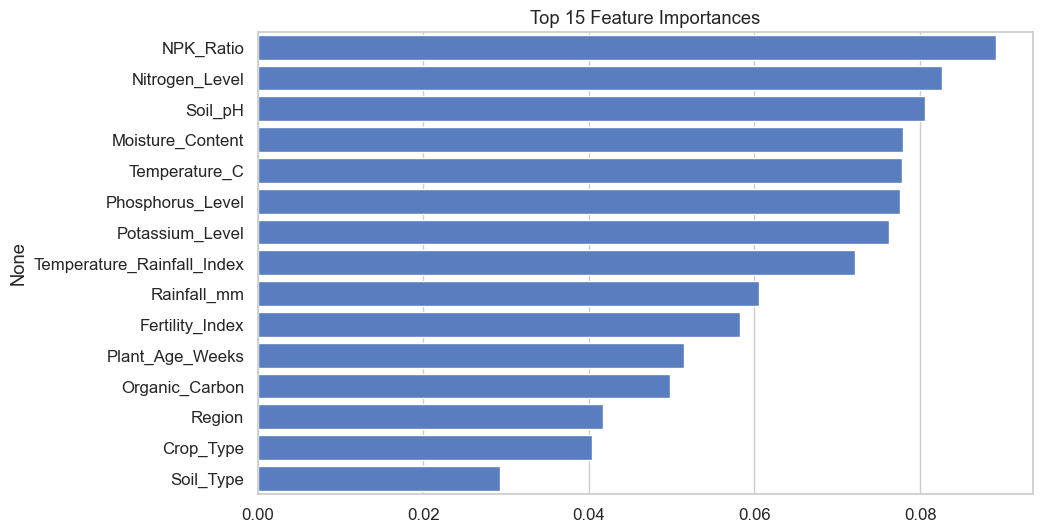

In [8]:
# ========================
# 8. Feature Importance Exploration (Optional)
# ========================


from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100, random_state=42)


X = train.drop(['Recommended_Quantity_kg_per_acre','Fertilizer_Type'], axis=1)
y = train['Recommended_Quantity_kg_per_acre']


rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)


plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title('Top 15 Feature Importances')
plt.show()

In [9]:
# ========================
# 9. Save Preprocessing Artifacts
# ========================
import joblib
from pathlib import Path

# Create 'models' folder if it doesn’t exist
models_dir = Path('../models')  # use ../ if your notebook is inside 'notebooks'
models_dir.mkdir(parents=True, exist_ok=True)

# Save artifacts
joblib.dump(scaler, models_dir / 'scaler.pkl')
joblib.dump(label_encoders, models_dir / 'label_encoders.pkl')

print(f'✅ Preprocessing artifacts saved in: {models_dir.resolve()}')


✅ Preprocessing artifacts saved in: C:\Users\sasik\OneDrive\Desktop\AIML Project\models
